# SINDyCP Feature Overview
This notebook provides an overview of the SINDyCP for discovery of parameterized pattern formation in PySINDy. Jupyter notebook written by Zachary G. Nicolaou.

Model pattern formation equations typically encode the effects of external drive through a number of driving parameters, which characterize a bifurcation leading to the onset of instability. While driving parameters can be considered as constant control signals for spatiotemporal dynamics, combining the PDEFIND and SINDYc approaches to discover parameterized spatiotemporal dynamics poses a significant challenge.
Here, we develop the system identification for nonlinear dynamics with control parameters (SINDyCP) approach to discover such parameterized dynamics.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dynamicslab/pysindy/v1.7.3?filepath=examples/17_parameterized_pattern_formation/parameterized_pattern_formation.ipynb)

In [1]:
import matplotlib.pyplot as plt
import pysindy as ps
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.stats import linregress
from scipy.signal import find_peaks
import timeit
import os
import utils

colors = [
    "#ff7f0e",
    "#2ca02c",
    "#1f77b4",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]

### Fit a parameterized logistic map
The logistic map
$$ x_{n+1} = r x_n(1-x_n)$$
depends on one parameter $r$.  The behavior is chaotic for r>3.6

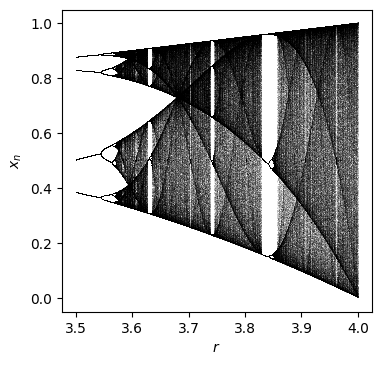

In [2]:
num = 1000
N = 1000
N_drop = 500
r0 = 3.5
rs = r0 + np.arange(num) / num * (4 - r0)
xss = []
for r in rs:
    xs = []
    x = 0.5
    for n in range(N + N_drop):
        if n >= N_drop:
            xs = xs + [x]
        x = r * x * (1 - x)
    xss = xss + [xs]

plt.figure(figsize=(4, 4), dpi=100)
for ind in range(num):
    plt.plot(np.ones(N) * rs[ind], xss[ind], ",", alpha=0.1, c="black", rasterized=True)
plt.xlabel("$r$")
plt.ylabel("$x_n$")
plt.savefig("logistic.pdf")
plt.show()

Generate data for four trajectories with differing values of $r=3.6,3.7,3.8,3.9$.

In [3]:
N = 1000
N_drop = 500

rs = [3.6, 3.7, 3.8, 3.9]
xss = []
for r in rs:
    xs = []
    x = 0.5
    for n in range(N + N_drop):
        if n >= N_drop:
            xs = xs + [x]
        x = r * x * (1 - x)
    xss = xss + [np.array(xs)]

Create a SINDyCP library, with a polynomial degree 3 feature library and a polynomial degree 1 parameter library. The library terms in a SINDyCP library consists of products of the features in the feature library and the parameter library. We input specify the parameter values for each trajectory using the control input, which must be the same shape as the input data.

In [4]:
feature_lib = ps.PolynomialLibrary(degree=3, include_bias=True)
parameter_lib = ps.PolynomialLibrary(degree=1, include_bias=True)
lib = ps.ParameterizedLibrary(
    feature_library=feature_lib,
    parameter_library=parameter_lib,
    num_features=1,
    num_parameters=1,
)
opt = ps.STLSQ(threshold=1e-1, normalize_columns=False)
model = ps.SINDy(
    feature_library=lib, optimizer=opt, feature_names=["x", "r"], discrete_time=True
)
# model.fit(xss, u=[np.ones(N) * rs[ind] for ind in range(len(rs))], multiple_trajectories=True)
model.fit(xss, u=rs, multiple_trajectories=True)
model.print()

(x)[k+1] = 1.000 r[k] x[k] + -1.000 r[k] x[k]^2


### Fit a parameterized Lorenz model
The Lorenz equations
$$ \dot{x} = \sigma (y - x),$$
$$ \dot{y} = x(\rho - z) - y, $$
$$ \dot{z} = x y - \beta z. $$
depend on 3 parameters, $\sigma$, $\rho$, and $\beta$. We generate 10 trajectories with different parameter values.

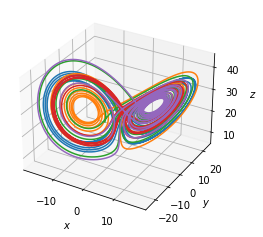

In [5]:
num_trajectories = 5
scalesigma = 1
scalerho = 1
scalebeta = 1
dt = 0.002

np.random.seed(100)
sigmas = 10 + scalesigma * (np.random.random(num_trajectories) - 0.5)
rhos = 28 * np.ones(num_trajectories) + scalerho * (
    np.random.random(num_trajectories) - 0.5
)
betas = 2.66667 * np.ones(num_trajectories) + scalebeta * (
    np.random.random(num_trajectories) - 0.5
)

x_trains, t_trains = utils.get_lorenz_trajectories(sigmas, rhos, betas, dt)

fig = plt.figure(figsize=(4, 4))
ax = plt.axes(projection="3d")

for i in range(len(x_trains)):
    ax.plot(x_trains[i][:, 0], x_trains[i][:, 1], x_trains[i][:, 2])

ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_zlabel("$z$")
plt.savefig("lorenz.pdf")
plt.show()

Fitting any one trajectory gives the equation corresponding to a specific set of parameter values. Can we discover the parameterized equations given all the trajectories?

In [6]:
lib = ps.PolynomialLibrary()
opt = ps.STLSQ(threshold=1e-1, normalize_columns=False)
model = ps.SINDy(
    feature_library=lib,
    optimizer=opt,
    feature_names=["x", "y", "z", "sigma", "rho", "beta"],
)
model.fit(x_trains[-1], t=dt)
model.print()
print([sigmas[-1], rhos[-1], betas[-1]])
print(lib.get_feature_names(["x", "y", "z", "sigma", "rho", "beta"]))

(x)' = -9.504 x + 9.504 y
(y)' = 28.068 x + -0.999 y + -1.000 x z
(z)' = -2.386 z + 1.000 x y
[9.504718856190973, 28.07509332942725, 2.3863674926249923]
['1', 'x', 'y', 'z', 'x^2', 'x y', 'x z', 'y^2', 'y z', 'z^2']


We use the control input of ps.model to specify the parameter values, and fit a SINDy model with multiple trajectories.

PySINDy will broadcast the control input shape to match the input data shape internally, so we send a list of the parameter values for each trajectory

Fitting a PolynomialLibrary with multiple_trajectories=True gives the correct model, but note that the same library functions are applied to the input features and the control input.

In [7]:
u_trains = [[sigmas[i], rhos[i], betas[i]] for i in range(len(sigmas))]
lib = ps.PolynomialLibrary()
opt = ps.STLSQ(threshold=1e-1, normalize_columns=False)
model = ps.SINDy(
    feature_library=lib,
    optimizer=opt,
    feature_names=["x", "y", "z", "sigma", "rho", "beta"],
)
model.fit(x_trains, u=u_trains, t=dt, multiple_trajectories=True)
model.print()
print(lib.get_feature_names(["x", "y", "z", "sigma", "rho", "beta"]))

(x)' = -1.000 x sigma + 1.000 y sigma
(y)' = -0.999 y + -1.000 x z + 1.000 x rho
(z)' = 1.000 x y + -1.000 z beta
['1', 'x', 'y', 'z', 'sigma', 'rho', 'beta', 'x^2', 'x y', 'x z', 'x sigma', 'x rho', 'x beta', 'y^2', 'y z', 'y sigma', 'y rho', 'y beta', 'z^2', 'z sigma', 'z rho', 'z beta', 'sigma^2', 'sigma rho', 'sigma beta', 'rho^2', 'rho beta', 'beta^2']


The ParameterizedLibrary enables different libraries to be applied to the control input and input features. In this case, the result is the same, but different libraries are required for the PDE case, as shown below.

In [8]:
feature_library = ps.PolynomialLibrary(degree=2)
parameter_library = ps.PolynomialLibrary(degree=1)
lib = ps.ParameterizedLibrary(
    feature_library=feature_library,
    parameter_library=parameter_library,
    num_parameters=3,
)
opt = ps.STLSQ(threshold=1e-1, normalize_columns=False)
model = ps.SINDy(
    feature_library=lib,
    optimizer=opt,
    feature_names=["x", "y", "z", "sigma", "rho", "beta"],
)
model.fit(x_trains, u=u_trains, t=dt, multiple_trajectories=True)
model.print()
print(lib.get_feature_names(["x", "y", "z", "sigma", "rho", "beta"]))

(x)' = -1.000 sigma x + 1.000 sigma y
(y)' = -0.999 1 y + -1.000 1 x z + 1.000 rho x
(z)' = 1.000 1 x y + -1.000 beta z
['1 1', '1 x', '1 y', '1 z', '1 x^2', '1 x y', '1 x z', '1 y^2', '1 y z', '1 z^2', 'sigma 1', 'sigma x', 'sigma y', 'sigma z', 'sigma x^2', 'sigma x y', 'sigma x z', 'sigma y^2', 'sigma y z', 'sigma z^2', 'rho 1', 'rho x', 'rho y', 'rho z', 'rho x^2', 'rho x y', 'rho x z', 'rho y^2', 'rho y z', 'rho z^2', 'beta 1', 'beta x', 'beta y', 'beta z', 'beta x^2', 'beta x y', 'beta x z', 'beta y^2', 'beta y z', 'beta z^2']


In [9]:
if __name__ == "testing":
    quit()

### Fit a parameterized complex Ginzburg-Landau equation
The complex Ginzburg-Landau equation
$$ \dot{A} = A + (1+ib)\nabla^2 A - (1-ic)|A|^2A$$
describes the evolution of the mode amplitude $A$ for pattern formation in a long-wavelength, supercritical Hopf bifurcation. It depends on two parameters $b$ and $c$. We generate 4 trajectories with different values of the parameters. (Note: this will take a few minutes on the first run, but trajectories are saved and reloaded if present)

In [10]:
nx = 128
ny = 128
L = 16
t1 = 2e2
t3 = 1.9e2
dt = 1e-1
nt = int((t1 - t3) / dt)

spatial_grid = np.zeros((nx, ny, 2))
spatial_grid[:, :, 0] = (np.arange(nx) - nx // 2)[:, np.newaxis] * 2 * np.pi * L / nx
spatial_grid[:, :, 1] = (np.arange(nx) - nx // 2)[np.newaxis, :] * 2 * np.pi * L / nx
spatiotemporal_grid = np.zeros((nx, ny, nt, 3))
spatiotemporal_grid[:, :, :, :2] = spatial_grid[:, :, np.newaxis, :]
spatiotemporal_grid[:, :, :, 2] = dt * np.arange(nt)

In [11]:
bs = [2.0, 2.0, 0.5, 1.0]
cs = [1.0, 0.75, 0.5, 0.75]
scales = [1e-1, 1e-1, 1e-1, 1e0]
scales2 = [1e-2, 1e-2, 1e0, 1e-2]
us = [[bs[i], cs[i]] for i in range(len(bs))]

if np.all([os.path.exists("data/cgle/cgle_x" + str(i) + ".npy") for i in range(4)]):
    xs = [np.load("data/cgle/cgle_x" + str(i) + ".npy") for i in range(4)]
else:
    xs = []
    for i in range(len(bs)):
        b = bs[i]
        c = cs[i]
        scale0 = scales[i]
        scale2 = scales2[i]
        x0 = utils.get_cgle_ic(scale0, scale2, spatial_grid)
        x = utils.get_cgle_trajectory(b, c, x0, t1, t3, dt, spatial_grid)
        xs = xs + [x]
    for i in range(len(xs)):
        if not os.path.exists("data/cgle"):
            os.mkdir("data/cgle")
        np.save("data/cgle/cgle_x" + str(i), xs[i])
# utils.animate_clge(xs,us)

Depending on the parameter values and initial conditions, the system exhibits different dynamical phases.

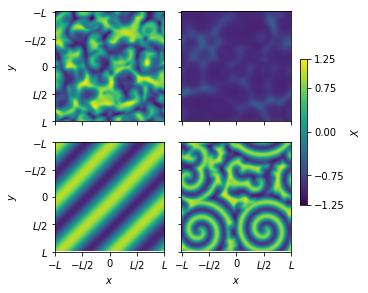

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(5, 4), constrained_layout=True)

for i in range(len(xs)):
    plt.subplot(2, 2, i + 1)
    pl = plt.imshow(xs[i][:, :, -1, 0], vmin=-1.25, vmax=1.25)
    plt.gca().set_xticks([0, 32, 64, 96, 128])
    plt.gca().set_xticklabels(["$-L$", "$-L/2$", "0", "$L/2$", "$L$"])
    plt.gca().set_yticks([0, 32, 64, 96, 128])
    plt.gca().set_yticklabels(["$-L$", "$-L/2$", "0", "$L/2$", "$L$"])
    if i == 2 or i == 3:
        plt.xlabel("$x$")
    else:
        plt.gca().set_xticklabels([])
    if i == 0 or i == 2:
        plt.ylabel("$y$")
    else:
        plt.gca().set_yticklabels([])

cbar = plt.colorbar(
    pl,
    ax=axs[:, 1],
    orientation="vertical",
    ticks=[-1.25, -0.75, 0.00, 0.75, 1.25],
    label="$X$",
    shrink=0.6,
)
plt.savefig("cgle.pdf")
plt.show()

Fitting any one trajectory gives the equation corresponding to a specific set of parameter values. Can we discover the parameterized equations given all the trajectories?

In [13]:
start = timeit.default_timer()
lib = ps.PDELibrary(
    library_functions=[
        lambda x: x,
        lambda x: x**3,
        lambda x, y: x**2 * y,
        lambda x, y: y**2 * x,
    ],
    derivative_order=2,
    spatial_grid=spatial_grid,
    include_interaction=False,
    function_names=[
        lambda x: x,
        lambda x: x + x + x,
        lambda x, y: x + x + y,
        lambda x, y: x + y + y,
    ],
    differentiation_method=ps.SpectralDerivative,
)
opt = ps.STLSQ(threshold=1e-1, alpha=1e-3)
model = ps.SINDy(feature_library=lib, optimizer=opt, feature_names=["X", "Y"])
model.fit(xs[-1], t=dt)
model.print()
stop = timeit.default_timer()
print(stop - start)

(X)' = 0.999 X + -0.999 XXX + -0.750 YYY + -0.750 XXY + -0.999 XYY + 0.999 X_22 + -0.999 Y_22 + 0.999 X_11 + -0.999 Y_11
(Y)' = 0.999 Y + 0.750 XXX + -0.999 YYY + -0.999 XXY + 0.750 XYY + 0.999 X_22 + 0.999 Y_22 + 0.999 X_11 + 0.999 Y_11
6.595068139024079


Try a SINDy model with multiple trajectories using the ParameterizedLibrary. Use a PDELibrary for the feature_library with second-order derivatives and library functions that include the relevant cubic term. Use a PDELibrary for the parameter_library with zeroth-order derivatives and linear library functions. The fit is very good!

In [14]:
start = timeit.default_timer()
library_functions = [
    lambda x: x,
    lambda x: x**3,
    lambda x, y: x**2 * y,
    lambda x, y: y**2 * x,
]
function_names = [
    lambda x: x,
    lambda x: x + x + x,
    lambda x, y: x + x + y,
    lambda x, y: x + y + y,
]
feature_lib = ps.PDELibrary(
    library_functions=library_functions,
    derivative_order=2,
    spatial_grid=spatial_grid,
    include_interaction=False,
    function_names=function_names,
)
library_functions = [lambda x: x]
function_names = [lambda x: x]
parameter_lib = ps.PDELibrary(
    library_functions=library_functions,
    derivative_order=0,
    include_interaction=False,
    function_names=function_names,
    include_bias=True,
)
lib = ps.ParameterizedLibrary(
    parameter_library=parameter_lib,
    feature_library=feature_lib,
    num_parameters=2,
    num_features=2,
)
opt = ps.STLSQ(threshold=5e-1, alpha=1e-3, normalize_columns=False)
model = ps.SINDy(feature_library=lib, optimizer=opt, feature_names=["x", "y", "b", "c"])
model.fit(xs, u=us, t=dt, multiple_trajectories=True)
model.print()
stop = timeit.default_timer()
print(stop - start)
print(lib.get_feature_names(["x", "y", "b", "c"]))

(x)' = 0.989 1 x + -0.987 1 xxx + -0.987 1 xyy + 1.018 1 x_22 + 1.019 1 x_11 + -1.020 b y_22 + -1.018 b y_11 + -1.000 c yyy + -1.000 c xxy
(y)' = 0.986 1 y + -0.984 1 yyy + -0.984 1 xxy + 1.012 1 y_22 + 1.017 1 y_11 + 1.016 b x_22 + 1.017 b x_11 + 0.999 c xxx + 1.000 c xyy
51.137652091216296
['1 x', '1 y', '1 xxx', '1 yyy', '1 xxy', '1 xyy', '1 x_2', '1 y_2', '1 x_22', '1 y_22', '1 x_1', '1 y_1', '1 x_12', '1 y_12', '1 x_11', '1 y_11', 'b x', 'b y', 'b xxx', 'b yyy', 'b xxy', 'b xyy', 'b x_2', 'b y_2', 'b x_22', 'b y_22', 'b x_1', 'b y_1', 'b x_12', 'b y_12', 'b x_11', 'b y_11', 'c x', 'c y', 'c xxx', 'c yyy', 'c xxy', 'c xyy', 'c x_2', 'c y_2', 'c x_22', 'c y_22', 'c x_1', 'c y_1', 'c x_12', 'c y_12', 'c x_11', 'c y_11']


Modifying PDELibrary to accept spectral derivatives improves the fit a bit

In [15]:
start = timeit.default_timer()
library_functions = [
    lambda x: x,
    lambda x: x**3,
    lambda x, y: x**2 * y,
    lambda x, y: y**2 * x,
]
function_names = [
    lambda x: x,
    lambda x: x + x + x,
    lambda x, y: x + x + y,
    lambda x, y: x + y + y,
]
feature_lib = ps.PDELibrary(
    library_functions=library_functions,
    derivative_order=2,
    spatial_grid=spatial_grid,
    include_interaction=False,
    function_names=function_names,
    differentiation_method=ps.SpectralDerivative,
)
library_functions = [lambda x: x]
function_names = [lambda x: x]
parameter_lib = ps.PDELibrary(
    library_functions=library_functions,
    derivative_order=0,
    include_interaction=False,
    function_names=function_names,
    include_bias=True,
)
lib = ps.ParameterizedLibrary(
    parameter_library=parameter_lib,
    feature_library=feature_lib,
    num_parameters=2,
    num_features=2,
)
opt = ps.STLSQ(threshold=1e-1, alpha=1e-3, normalize_columns=False)
model = ps.SINDy(feature_library=lib, optimizer=opt, feature_names=["x", "y", "b", "c"])
model.fit(xs, u=us, t=dt, multiple_trajectories=True)
model.print()
stop = timeit.default_timer()
print(stop - start)
print(lib.get_feature_names(["x", "y", "b", "c"]))

(x)' = 0.999 1 x + -0.999 1 xxx + -0.999 1 xyy + 0.999 1 x_22 + 0.999 1 x_11 + -0.999 b y_22 + -0.999 b y_11 + -0.999 c yyy + -0.999 c xxy
(y)' = 0.999 1 y + -0.999 1 yyy + -0.999 1 xxy + 0.999 1 y_22 + 0.999 1 y_11 + 0.999 b x_22 + 0.999 b x_11 + 0.999 c xxx + 0.999 c xyy
52.54230981133878
['1 x', '1 y', '1 xxx', '1 yyy', '1 xxy', '1 xyy', '1 x_2', '1 y_2', '1 x_22', '1 y_22', '1 x_1', '1 y_1', '1 x_12', '1 y_12', '1 x_11', '1 y_11', 'b x', 'b y', 'b xxx', 'b yyy', 'b xxy', 'b xyy', 'b x_2', 'b y_2', 'b x_22', 'b y_22', 'b x_1', 'b y_1', 'b x_12', 'b y_12', 'b x_11', 'b y_11', 'c x', 'c y', 'c xxx', 'c yyy', 'c xxy', 'c xyy', 'c x_2', 'c y_2', 'c x_22', 'c y_22', 'c x_1', 'c y_1', 'c x_12', 'c y_12', 'c x_11', 'c y_11']


If we ensure the same domain cells are used in the feature library and the parameter library (by reseeding np.random), the WeakLibrary can be used with the ParameterLibrary. (In this case, the parameters need to be constants, so that the tensor product of two WeakLibrary corresponds to the correct weak features.) The fit is perfect and super fast!

In [16]:
start = timeit.default_timer()
np.random.seed(100)
library_functions = [
    lambda x: x,
    lambda x: x**3,
    lambda x, y: x**2 * y,
    lambda x, y: y**2 * x,
]
function_names = [
    lambda x: x,
    lambda x: x + x + x,
    lambda x, y: x + x + y,
    lambda x, y: x + y + y,
]
feature_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    derivative_order=2,
    spatiotemporal_grid=spatiotemporal_grid,
    include_interaction=False,
    function_names=function_names,
    K=500,
    H_xt=[L * 2 * np.pi / 10, L * 2 * np.pi / 10, (t1 - t3) / 10],
)
np.random.seed(100)
library_functions = [lambda x: x]
function_names = [lambda x: x]
parameter_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    spatiotemporal_grid=spatiotemporal_grid,
    derivative_order=0,
    include_interaction=False,
    function_names=function_names,
    include_bias=True,
    K=500,
    H_xt=[L * 2 * np.pi / 10, L * 2 * np.pi / 10, (t1 - t3) / 10],
)
lib = ps.ParameterizedLibrary(
    parameter_library=parameter_lib,
    feature_library=feature_lib,
    num_parameters=2,
    num_features=2,
)
opt = ps.STLSQ(threshold=1e-1, alpha=1e-3, normalize_columns=False)
model = ps.SINDy(feature_library=lib, optimizer=opt, feature_names=["x", "y", "b", "c"])
model.fit(xs, u=us, t=dt, multiple_trajectories=True)
model.print()
stop = timeit.default_timer()
print(stop - start)
print(lib.get_feature_names(["x", "y", "b", "c"]))

(x)' = 1.000 1 x + -1.000 1 xxx + -1.000 1 xyy + 1.000 1 x_22 + 1.000 1 x_11 + -1.000 b y_22 + -1.000 b y_11 + -1.000 c yyy + -1.000 c xxy
(y)' = 1.000 1 y + -1.000 1 yyy + -1.000 1 xxy + 1.000 1 y_22 + 1.000 1 y_11 + 1.000 b x_22 + 1.000 b x_11 + 1.000 c xxx + 1.000 c xyy
11.88535311166197
['1 x', '1 y', '1 xxx', '1 yyy', '1 xxy', '1 xyy', '1 x_2', '1 y_2', '1 x_22', '1 y_22', '1 x_1', '1 y_1', '1 x_12', '1 y_12', '1 x_11', '1 y_11', 'b x', 'b y', 'b xxx', 'b yyy', 'b xxy', 'b xyy', 'b x_2', 'b y_2', 'b x_22', 'b y_22', 'b x_1', 'b y_1', 'b x_12', 'b y_12', 'b x_11', 'b y_11', 'c x', 'c y', 'c xxx', 'c yyy', 'c xxy', 'c xyy', 'c x_2', 'c y_2', 'c x_22', 'c y_22', 'c x_1', 'c y_1', 'c x_12', 'c y_12', 'c x_11', 'c y_11']


### Oregenator model for BZ chemical reaction

We consider the coupled reaction diffusion equations

$\dot{C}_X = k_1 C_A C_H^2 C_Y-k_2C_HC_XC_Y+k_3C_AC_HC_X-2k_4C_X^2  + D_X \nabla^2 C_X$

$\dot{C}_Y = -k_1C_AC_H^2C_Y-k_2C_HC_XC_Y + \nu k_5 C_B C_Z + D_Y \nabla^2 C_Y$

$\dot{C}_Z = 2k_3C_AC_HC_X-k_5C_BC_Z + D_Z \nabla^2 C_Z$

which constitute the classical Oregonator model for the BZ chemical reaction. We fix all parameters except $C_b=C_b^c(1 - \mu)$, and a supercritical Hopf bifurcation occurs at $\mu=0$. In the spatially homogeneous case, a small, stable limit cycle initially emerges for $\mu>0$, but this limit cycle rapid expands in a canard explosion around $\mu\approx 0.15$.

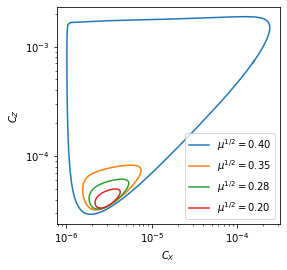

In [17]:
bs3 = np.linspace(0.84, 0.98, 8)

Xs = []
Ys = []
Zs = []
for b in bs3:
    t1 = 1e2 / (1 - b)  # Domain size in t directions
    dt = 5.94804 / 100

    X, Y, Z = utils.get_homogeneous_oregonator_trajectory(b, t1, dt)
    Xs = Xs + [X]
    Ys = Ys + [Y]
    Zs = Zs + [Z]

# discard initial transients
plt.figure(figsize=(4, 4))
for i in range(0, len(bs3), 2):
    X = Xs[i]
    Z = Zs[i]
    nt = X.shape[0]
    period = int(np.median(np.diff(find_peaks(X[nt // 2 :])[0]))) + 1
    plt.plot(
        X[-period:], Z[-period:], label=r"$\mu^{1/2} = %.2f$" % ((1 - bs3[i]) ** 0.5)
    )
plt.xlabel("$C_X$")
plt.ylabel("$C_Z$")
plt.xscale("log")
plt.yscale("log")
plt.legend()

plt.savefig("fig2b.pdf")
plt.show()

Generate several trajectories. This will take several hours on the first run, but files will be saved and reloaded subsequently.

In [18]:
utils.generate_oregonator_trajectories()

Plot a finely resolved trajectory above the canard explosion, with $\mu=0.16$. The dynamics exhibit more extreme spatiotemporal variations than exhibited by the CGLE.

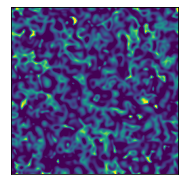

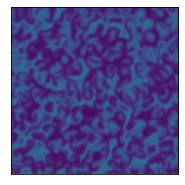

In [19]:
plt.figure(figsize=(3, 4))
x = np.load("data/oregonator/canard_0.npy")
plt.imshow(x[:, :, -1, 0])
plt.clim(2e-6, 8e-6)
plt.xticks([])
plt.yticks([])
plt.savefig("fig2c.pdf")
plt.show()
plt.figure(figsize=(3, 4))
x = np.load("data/oregonator/canard_1.npy")
plt.imshow(x[:, :, -1, 0])
plt.clim(2e-6, 8e-6)
plt.xticks([])
plt.yticks([])
plt.savefig("fig2d.pdf")
plt.show()
# utils.animate_oregonator()

Do a SINDyCP fit on unprocessed decaying trajectories to localize the Hopf point

(X)' = 0.374 1 X + -1.832 1 Z + 0.455 C_B X + -0.292 C_B Z
(Z)' = -0.035 1 X + 0.028 1 Z + 0.977 C_B X + -0.968 C_B Z
22.40487026097253


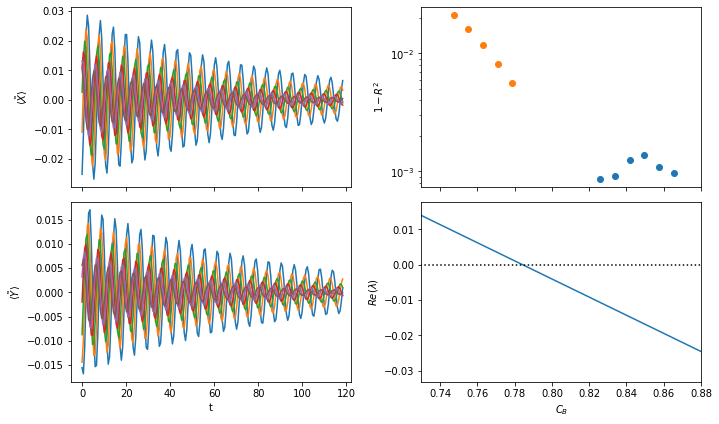

In [20]:
bs = np.concatenate([np.linspace(1.05, 1.1, 6), np.linspace(0.95, 0.99, 5)])
b0 = 0.95
L = 1 / np.abs(1 - b0) ** 0.5  # Domain size in X and Y directions
spatial_grid = np.zeros((n, n, 2))
spatial_grid[:, :, 0] = L / n * np.arange(n)[:, np.newaxis]
spatial_grid[:, :, 1] = L / n * np.arange(n)[np.newaxis, :]
t1 = 2e1 / np.abs(1 - b0)  # Domain size in t directions
dt = 5.94804 / 10
n = 128

xs = [np.load("data/oregonator/oregonator2_" + str(i) + ".npy") for i in range(len(bs))]
xs_train = []
xs_test = []
scales = []

us = (0.786642 * bs).tolist()
x0s = []
Nt = 200
for i in range(len(bs)):
    x0 = np.mean(xs[i][:, :, -100:], axis=(0, 1, 2))
    x0s = x0s + [x0]
    scale = x0
    xs_train = xs_train + [
        (xs[i][:, :, Nt : 2 * Nt, [0, 2]] - x0[[0, 2]]) / scale[[0, 2]]
    ]
    xs_test = xs_train + [
        (xs[i][:, :, 2 * Nt : 3 * Nt, [0, 2]] - x0[[0, 2]]) / scale[[0, 2]]
    ]
    scales = scales + [scale]

library_functions = [
    lambda x: x,
]
function_names = [
    lambda x: x,
]

feature_lib = ps.PDELibrary(
    library_functions=library_functions,
    derivative_order=2,
    spatial_grid=spatial_grid,
    include_interaction=False,
    include_bias=True,
    function_names=function_names,
    differentiation_method=ps.SpectralDerivative,
    multiindices=[],
)

library_functions = [lambda x: x]
function_names = [lambda x: x]

parameter_lib = ps.PDELibrary(
    library_functions=library_functions,
    derivative_order=0,
    include_interaction=False,
    function_names=function_names,
    include_bias=True,
)
lib = ps.ParameterizedLibrary(
    parameter_library=parameter_lib,
    feature_library=feature_lib,
    num_parameters=1,
    num_features=2,
)

opt = ps.STLSQ(threshold=1e-2, alpha=1e-12, normalize_columns=False)

model = ps.SINDy(feature_library=lib, optimizer=opt, feature_names=["X", "Z", "C_B"])

start = timeit.default_timer()
model.fit(xs_train[:6], u=us[:6], t=dt, multiple_trajectories=True)
model.print()
stop = timeit.default_timer()
print(stop - start)
scores = []
for i in range(len(us)):
    scores = scores + [
        model.score(
            xs_test[i],
            u=us[i],
            t=dt,
            multioutput="raw_values",
            multiple_trajectories=False,
        )
    ]

plt.subplots(2, 2, figsize=(10, 6))

plt.subplot(2, 2, 1)
for x in xs_train[:6]:
    plt.plot(dt * np.arange(200), np.mean(x[:, :, :, 0], axis=(0, 1)))
plt.ylabel(r"$\langle \tilde{X} \rangle$")
locs, labels = plt.xticks()
plt.xticks(locs, [])
plt.xlim(-5, 205 * dt)

plt.subplot(2, 2, 3)
for x in xs_train[:6]:
    plt.plot(dt * np.arange(200), np.mean(x[:, :, :, 1], axis=(0, 1)))
plt.xlim(-5, 205 * dt)

plt.xlabel("t")
plt.ylabel(r"$\langle \tilde{Y} \rangle$")

plt.subplot(2, 2, 2)
plt.scatter(0.786642 * bs[:6], 1 - np.mean(scores[:6], axis=1))
plt.scatter(0.786642 * bs[6:], 1 - np.mean(scores[6:], axis=1))
plt.yscale("log")
plt.ylabel(r"$1-R^2$")
locs, labels = plt.xticks()
plt.xticks(locs, [])

plt.xlim(0.73, 0.88)


plt.subplot(2, 2, 4)
bs2 = np.flip(np.linspace(0.92, 1.15, 1000))
lambdas, J = utils.get_linear_eigenvalues(model, 0.786642 * bs2)
plt.plot(0.786642 * bs2, np.real(lambdas)[:, 0])
plt.plot(0.786642 * bs2, 0 * np.real(lambdas)[:, 0], c="black", ls=":")
plt.xlabel(r"$C_B$")
plt.ylabel(r"$Re(\lambda)$")
plt.xlim(0.73, 0.88)
plt.tight_layout()
plt.savefig("figs3.pdf")
plt.show()

Construct the amplitude from the same data and attempt a SINDyCP fit

(X)' = 0.191 1 X + 0.163 1 Z + -1.628 1 XX + -1.356 1 ZZ + 0.834 1 XZ + -24.868 1 XXX + 28.160 1 ZZZ + 33.179 1 XXZ + -16.636 1 XZZ + 1.231 1 X_22 + 0.349 1 Z_22 + 1.214 1 X_11 + 0.350 1 Z_11 + -1.975 mu X + -1.542 mu Z + 11.824 mu XX + 12.331 mu ZZ + -4.941 mu XZ + 126.916 mu XXX + -44.357 mu ZZZ + -80.714 mu XXZ + 65.413 mu XZZ + -0.484 mu X_22 + -1.361 mu Z_22 + -0.344 mu X_11 + -1.390 mu Z_11 + 8.690 mumu X + 25.604 mumu Z + 18.764 mumu XX + 24.188 mumu ZZ + 3.051 mumu XZ + 281.099 mumu XXX + -74.515 mumu ZZZ + -118.407 mumu XXZ + 141.665 mumu XZZ + -0.957 mumu X_22 + -3.382 mumu Z_22 + -0.677 mumu X_11 + -3.459 mumu Z_11
(Z)' = -0.246 1 X + -0.981 1 XX + 0.456 1 ZZ + -0.862 1 XZ + -27.408 1 XXX + -15.098 1 ZZZ + -14.839 1 XXZ + -17.396 1 XZZ + -0.172 1 X_22 + 1.178 1 Z_22 + -0.161 1 X_11 + 1.177 1 Z_11 + 2.401 mu X + 8.051 mu XX + -1.047 mu ZZ + 4.977 mu XZ + 40.025 mu XXX + 37.491 mu ZZZ + 29.917 mu XXZ + -33.201 mu XZZ + -0.320 mu X_22 + -0.411 mu X_11 + -22.813 mumu X + 14.423 

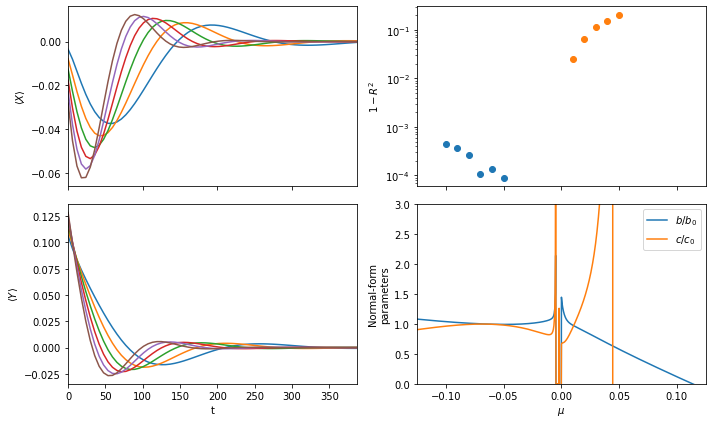

In [21]:
bs = np.concatenate([np.linspace(1.05, 1.1, 6), np.linspace(0.95, 0.99, 5)])
n = 128

xs_train = []
xs_test = []
scales = []
us = (1 - bs).tolist()
x0s = []
Nt = xs[0].shape[2] // 5 // 10 * 10
for i in range(len(bs)):
    x = np.load("data/oregonator/oregonator2_" + str(i) + ".npy")
    Nt = 10
    x0 = np.mean(x[:, :, -Nt:, [0, 2]], axis=(0, 1, 2))
    U = (x[:, :, Nt:, [0, 2]] - x0) / x0
    nt = U.shape[2] // 10 * 10
    A = np.mean(
        (
            (U[:, :, :, 0] + 1j * U[:, :, :, 1])
            * np.exp(-1j * 2 * np.pi / 10 * np.arange(U.shape[2]))
        )[:, :, :nt].reshape(n, n, nt // 10, 10),
        axis=3,
    )
    x_train = np.array([np.real(A), np.imag(A)]).transpose(1, 2, 3, 0)[:, :, : nt // 10]
    x_test = np.array([np.real(A), np.imag(A)]).transpose(1, 2, 3, 0)[
        :, :, nt // 10 // 2 :
    ]
    xs_train = xs_train + [x_train]
    xs_test = xs_test + [x_test]

L = 2e2  # Domain size in X and Y directions
spatial_grid = np.zeros((n, n, 2))
spatial_grid[:, :, 0] = L / n * np.arange(n)[:, np.newaxis]
spatial_grid[:, :, 1] = L / n * np.arange(n)[np.newaxis, :]
dt = 1e-1

library_functions = [
    lambda x: x,
    lambda x: x**2,
    lambda x, y: x * y,
    lambda x: x**3,
    lambda x, y: x**2 * y,
    lambda x, y: y**2 * x,
]
function_names = [
    lambda x: x,
    lambda x: x + x,
    lambda x, y: x + y,
    lambda x: x + x + x,
    lambda x, y: x + x + y,
    lambda x, y: x + y + y,
]

feature_lib = ps.PDELibrary(
    library_functions=library_functions,
    derivative_order=2,
    spatial_grid=spatial_grid,
    include_interaction=False,
    include_bias=True,
    function_names=function_names,
    differentiation_method=ps.SpectralDerivative,
)

library_functions = [lambda x: np.abs(x) ** 0.5, lambda x: x]
function_names = [lambda x: x, lambda x: x + x]

parameter_lib = ps.PDELibrary(
    library_functions=library_functions,
    derivative_order=0,
    include_interaction=False,
    function_names=function_names,
    include_bias=True,
)
lib = ps.ParameterizedLibrary(
    parameter_library=parameter_lib,
    feature_library=feature_lib,
    num_parameters=1,
    num_features=2,
)

opt = ps.STLSQ(threshold=1e-1, alpha=1e-12, normalize_columns=False)

model = ps.SINDy(feature_library=lib, optimizer=opt, feature_names=["X", "Z", "mu"])

start = timeit.default_timer()
model.fit(xs_train[:6], u=us[:6], t=dt, multiple_trajectories=True)
model.print()
stop = timeit.default_timer()
print(stop - start)
scores = []
for i in range(len(us)):
    scores = scores + [
        model.score(
            xs_test[i],
            u=us[i],
            t=dt,
            multioutput="raw_values",
            multiple_trajectories=False,
        )
    ]

bs2 = np.linspace(0.9, 1.1, 1000)
alphas, betas = utils.get_normal_form_parameters(model, 1 - bs2)

plt.subplots(2, 2, figsize=(10, 6))

plt.subplot(2, 2, 1)
for x in xs_train[:6]:
    plt.plot(5.94804 * np.arange(x.shape[2]), np.mean(x[:, :, :, 0], axis=(0, 1)))

plt.ylabel(r"$\langle X \rangle$")
locs, labels = plt.xticks()
plt.xticks(locs, [])
plt.xlim(0, 650 * 5.94804 / 10)

plt.subplot(2, 2, 3)
for x in xs_train[:6]:
    plt.plot(5.94804 * np.arange(x.shape[2]), np.mean(x[:, :, :, 1], axis=(0, 1)))
plt.xlim(0, 650 * 5.94804 / 10)

plt.xlabel("t")
plt.ylabel(r"$\langle Y \rangle$")

plt.subplot(2, 2, 2)
plt.scatter((1 - bs)[:6], 1 - np.mean(scores[:6], axis=1))
plt.scatter((1 - bs)[6:], 1 - np.mean(scores[6:], axis=1))
plt.yscale("log")
plt.yscale("log")
plt.ylabel(r"$1-R^2$")
plt.xlim(-0.125, 0.125)
locs, labels = plt.xticks()
plt.xticks(locs, [])
plt.xlim(-0.125, 0.125)

plt.subplot(2, 2, 4)
bs2 = np.linspace(0.875, 1.125, 1000)
alphas, betas = utils.get_normal_form_parameters(model, 1 - bs2)
plt.plot((1 - bs2), np.sign(1 - bs2) * (betas / (0.17272)), label=r"$b/b_0$")
plt.plot((1 - bs2), np.sign(1 - bs2) * (alphas / (2.37882)), label=r"$c/c_0$")
plt.ylim(0, 3)
# plt.yscale('log')
plt.legend()
plt.ylabel("Normal-form\nparameters")
plt.xlabel(r"$\mu$")
plt.xlim(-0.125, 0.125)

plt.tight_layout()
plt.savefig("figs4.pdf")
plt.show()

Do the SINDyCP fit on more informative amplitudes constructed past the Hopf bifurcation, with implicit terms included.  The SINDyCP fit reveals variations in the normal-form parameter that correct the weakly-nonlinear theory away from the instability, and these variations become extreme at the canard explosion.  First, split the trajectories into training and test data and define a quadrative parameter and a quintic feature libraries. Plot the normal-form parameters as a function of $\varepsilon$. The fit agrees with the weakly nonlinear prediction in the $\mu\to 0$ limit, and the variation with $\mu$ represents a correction to the theory. The variations become extreme around the canard explosion that occurs above $\mu^{1/2}=0.35$.

(X)' = 1.402 X + 4.184 Y + -0.694 XXX + 1.887 YYY + 1.881 XXY + -0.664 XYY + 2.375 X_22 + 0.419 Y_22 + 2.374 X_11 + 0.419 Y_11
(Y)' = -4.219 X + 1.390 Y + -1.877 XXX + -0.763 YYY + -0.791 XXY + -1.893 XYY + -0.474 X_22 + 2.365 Y_22 + -0.475 X_11 + 2.365 Y_11
16.329759368672967

(X)' = 1.416 1 X + 4.546 1 Y + 0.140 1 XY + -0.829 1 XXX + 1.578 1 YYY + 1.601 1 XXY + -0.868 1 XYY + 2.168 1 X_22 + 0.551 1 Y_22 + 2.160 1 X_11 + 0.557 1 Y_11 + 0.177 mu 1 + 1.667 mu X + -1.894 mu Y + -0.435 mu XX + -0.331 mu YY + -1.613 mu XY + -0.468 mu XXX + 5.332 mu YYY + 4.878 mu XXY + -0.123 mu XYY + -0.697 mu X_t + 4.849 mu X_22 + -0.837 mu Y_22 + 4.920 mu X_11 + -0.898 mu Y_11 + -1.225 mumu 1 + -6.718 mumu X + 8.275 mumu Y + 3.906 mumu XX + 1.729 mumu YY + 4.686 mumu XY + 7.080 mumu XXX + -14.912 mumu YYY + -13.084 mumu XXY + 8.160 mumu XYY + 1.831 mumu X_t + -14.472 mumu X_22 + 1.028 mumu Y_22 + -14.609 mumu X_11 + 1.158 mumu Y_11
(Y)' = -4.519 1 X + 1.164 1 Y + -0.155 1 XY + -1.538 1 XXX + -0.688 1 YY

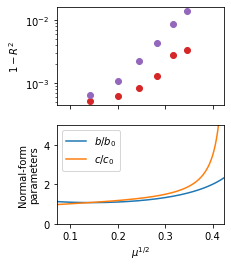

In [22]:
bs = np.linspace(0.88, 0.98, 6)
n = 128  # Number of spatial points in each direction

xs_train = []
xs_test = []
scales = []
for j in range(len(bs)):
    A = np.load("data/oregonator/oregonator_" + str(j) + ".npy")
    scale = np.mean(np.abs(A) ** 2) ** 0.5
    scales = scales + [scale]
    xsi = np.array([np.real(A) / scale, np.imag(A) / scale]).transpose([1, 2, 3, 0])
    xs_train = xs_train + [xsi[:, :, :250]]
    xs_test = xs_test + [xsi[:, :, 250:]]
us = (1 - bs).tolist()
L = 2e2  # Domain size in X and Y directions
spatial_grid = np.zeros((n, n, 2))
spatial_grid[:, :, 0] = L / n * np.arange(n)[:, np.newaxis]
spatial_grid[:, :, 1] = L / n * np.arange(n)[np.newaxis, :]
dt = 1e-1

library_functions = [
    lambda x: x,
    lambda x: x**2,
    lambda x, y: x * y,
    lambda x: x**3,
    lambda x, y: x**2 * y,
    lambda x, y: y**2 * x,
]
function_names = [
    lambda x: x,
    lambda x: x + x,
    lambda x, y: x + y,
    lambda x: x + x + x,
    lambda x, y: x + x + y,
    lambda x, y: x + y + y,
]

feature_lib0 = ps.PDELibrary(
    library_functions=library_functions,
    derivative_order=2,
    spatial_grid=spatial_grid,
    include_interaction=False,
    include_bias=True,
    function_names=function_names,
    differentiation_method=ps.SpectralDerivative,
)

opt0 = ps.STLSQ(threshold=1e-1, alpha=1e-12, normalize_columns=False)

model0 = ps.SINDy(
    feature_library=feature_lib0, optimizer=opt0, feature_names=["X", "Y"]
)

start = timeit.default_timer()
model0.fit(xs_train[-1], t=dt, multiple_trajectories=False)
model0.print()
stop = timeit.default_timer()
print(stop - start)
utils.get_single_normal_form_parameters(model0)

scores0 = []
for i in range(len(us)):
    scores0 = scores0 + [
        model0.score(
            xs_test[i],
            u=us[i],
            t=dt,
            multioutput="raw_values",
            multiple_trajectories=False,
        )
    ]

print()

feature_lib = ps.PDELibrary(
    library_functions=library_functions,
    derivative_order=2,
    spatial_grid=spatial_grid,
    temporal_grid=dt * np.arange(500),
    include_interaction=False,
    implicit_terms=True,
    include_bias=True,
    function_names=function_names,
    differentiation_method=ps.SpectralDerivative,
    multiindices=[[0, 0, 1], [1, 0, 0], [0, 1, 0], [1, 1, 0], [0, 2, 0], [2, 0, 0]],
)

library_functions = [lambda x: np.abs(x) ** 0.5, lambda x: x]
function_names = [lambda x: x, lambda x: x + x]

parameter_lib = ps.PDELibrary(
    library_functions=library_functions,
    derivative_order=0,
    include_interaction=False,
    function_names=function_names,
    include_bias=True,
)
lib = ps.ParameterizedLibrary(
    parameter_library=parameter_lib,
    feature_library=feature_lib,
    num_parameters=1,
    num_features=2,
)

opt = ps.STLSQ(threshold=1e-1, alpha=1e-12, normalize_columns=False)
model = ps.SINDy(feature_library=lib, optimizer=opt, feature_names=["X", "Y", "mu"])

start = timeit.default_timer()
model.fit(xs_train, u=us, t=dt, multiple_trajectories=True)
model.print()
stop = timeit.default_timer()
print(stop - start)

scores = []
for i in range(len(us)):
    scores = scores + [
        model.score(
            xs_test[i],
            u=us[i],
            t=dt,
            multioutput="raw_values",
            multiple_trajectories=False,
        )
    ]

bs2 = np.linspace(0.82, 0.995, 1000)
alphas, betas = utils.get_normal_form_parameters(model, 1 - bs2)

plt.subplots(2, 1, figsize=(3, 4))

plt.subplot(2, 1, 1)
plt.scatter((1 - bs) ** 0.5, 1 - np.mean(scores, axis=1), c=colors[3])
plt.scatter((1 - bs) ** 0.5, 1 - np.mean(scores0, axis=1), c=colors[4])

plt.ylabel("$1-R^2$")
plt.gca().set_xticks([0.1, 0.2, 0.3, 0.4])
plt.gca().set_xticklabels([])
plt.xlim((1 - bs2[-1]) ** 0.5, (1 - bs2[0]) ** 0.5)
plt.yscale("log")

plt.subplot(2, 1, 2)
plt.plot((1 - bs2) ** 0.5, betas / (0.17272), label=r"$b/b_0$")
plt.plot((1 - bs2) ** 0.5, alphas / (2.37882), label=r"$c/c_0$")
plt.gca().set_xticks([0.1, 0.2, 0.3, 0.4])
plt.ylim(0, 5)
plt.legend()
plt.ylabel("Normal-form\nparameters")
plt.xlabel(r"$\mu^{1/2}$")
plt.xlim((1 - bs2[-1]) ** 0.5, (1 - bs2[0]) ** 0.5)
plt.savefig("fig2a.pdf")
plt.show()

Compare the Canard explosions in the SINDyCP model and the Oregonator model

1076.3109875060618
190.66287575569004


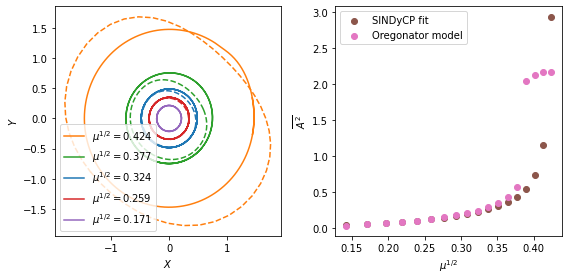

In [23]:
bs3 = np.linspace(0.82, 0.98, 18)

Xs2 = []
Ys2 = []
Zs2 = []
start = timeit.default_timer()
for b in bs3:
    t1 = 1e3 / (1 - b)  # Domain size in t directions
    dt = 5.94804 / 100

    X, Y, Z = utils.get_homogeneous_oregonator_trajectory(b, t1, dt)
    Xs2 = Xs2 + [X]
    Ys2 = Ys2 + [Y]
    Zs2 = Zs2 + [Z]

slope, intercept, r_value, p_value, std_err = linregress((1 - bs) ** 0.5, scales)
scales3 = intercept + slope * (1 - bs3) ** 0.5
stop = timeit.default_timer()
print(stop - start)

Xs = []
Ys = []
start = timeit.default_timer()
for b in bs3:
    t1 = 2e1  # Domain size in t directions
    dt = 5e-3

    X, Y = utils.get_homogeneous_oregonator_trajectory_fit(model, b, t1, dt)
    Xs = Xs + [X]
    Ys = Ys + [Y]
stop = timeit.default_timer()
print(stop - start)

amps = []
amps2 = []
for i in range(0, len(bs3)):
    X = Xs[i]
    Y = Ys[i]
    nt = X.shape[0]
    period = int(np.median(np.diff(find_peaks(X[nt // 2 :])[0]))) + 1
    amps = amps + [
        np.mean((scales3[i] * X[-period:]) ** 2 + (scales3[i] * Y[-period:]) ** 2)
    ]

for i in range(0, len(bs3)):
    X = Xs2[i]
    Z = Zs2[i]
    nt = X.shape[0]
    period = int(np.median(np.diff(find_peaks(X[nt // 2 :])[0]))) + 1
    x0 = np.mean(X[-10 * period :])
    z0 = np.mean(Z[-10 * period :])
    A2 = np.mean(
        (
            ((X[-300 * period :] - x0) / x0 + 1j * (Z[-300 * period :] - z0) / z0)
            * np.exp(-1j * 2 * np.pi / period * np.arange(300 * period))
        ).reshape(300, -1),
        axis=1,
    )
    amps2 = amps2 + [np.mean(np.abs(A2) ** 2)]

plt.subplots(1, 2, figsize=(8, 4))
plt.subplot(1, 2, 1)
for i in range(0, len(bs3), 4):
    X = Xs[i]
    Y = Ys[i]
    nt = X.shape[0]
    period = int(np.median(np.diff(find_peaks(X[nt // 2 :])[0]))) + 1
    plt.plot(
        (scales3[i] * X[-period:]),
        (scales3[i] * Y[-period:]),
        ls="--",
        c=colors[i // 4],
    )

    X = Xs2[i]
    Z = Zs2[i]
    nt = X.shape[0]
    period = int(np.median(np.diff(find_peaks(X[nt // 2 :])[0]))) + 1
    x0 = np.mean(X[-10 * period :])
    z0 = np.mean(Z[-10 * period :])
    A2 = np.mean(
        (
            ((X[-300 * period :] - x0) / x0 + 1j * (Z[-300 * period :] - z0) / z0)
            * np.exp(-1j * 2 * np.pi / period * np.arange(300 * period))
        ).reshape(300, -1),
        axis=1,
    )
    plt.plot(
        np.real(A2),
        np.imag(A2),
        c=colors[i // 4],
        label=r"$\mu^{1/2}=%.3f$" % ((1 - bs3[i]) ** 0.5),
    )

plt.xlabel(r"$X$")
plt.ylabel(r"$Y$")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter((1 - bs3) ** 0.5, amps, label="SINDyCP fit", c=colors[i // 4 + 1])
plt.scatter((1 - bs3) ** 0.5, amps2, label="Oregonator model", c=colors[i // 4 + 2])
plt.xlabel(r"$\mu^{1/2}$")
plt.ylabel(r"$\overline{A^2}$")
plt.legend()

plt.tight_layout()
plt.savefig("figs8.pdf")
plt.show()

### Effects of noise on CGLE fits

Here we perform both differential and weak SINDyCP fits on the four previous trajectories with various intensities of injected noise. We generate two new test trajectories to assess the performance of the fits. We also generate five new training trajectories with random parameter values in the amplitude turbulence parameter regime and perform the SINDyCP fits on noisy data with a varying number of length of trajectories. Since these fits take a while, we use previously saved score results here if they are present.

In [24]:
utils.cgle_weak_noise_sweeps()
utils.cgle_noise_sweeps()

Plot results

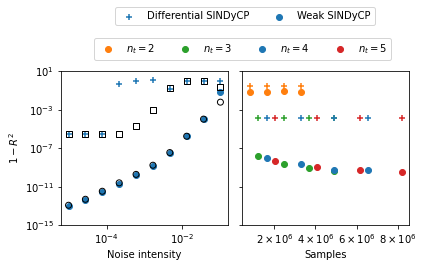

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

plt.subplot(1, 2, 1)
scores0 = np.load("data/cgle/cgle_scores0.npy")
weak_scores0 = np.load("data/cgle/cgle_weak_scores0.npy")
scores1 = np.load("data/cgle/cgle_scores1.npy")
weak_scores1 = np.load("data/cgle/cgle_weak_scores1.npy")
plt.scatter(
    scores0[:, 0],
    1 - scores0[:, 1],
    label="Differential SINDyCP",
    color=colors[2],
    marker="+",
)
plt.scatter(
    weak_scores0[:, 0], 1 - weak_scores0[:, 1], label="Weak SINDyCP", color=colors[2]
)
plt.scatter(
    scores1[:, 0],
    1 - scores1[:, 1],
    color=colors[2],
    marker="s",
    facecolor="none",
    edgecolor="black",
)
plt.scatter(
    weak_scores1[:, 0],
    1 - weak_scores1[:, 1],
    color=colors[2],
    facecolor="none",
    edgecolor="black",
)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Noise intensity")
plt.ylabel("$1-R^2$")
plt.ylim(10**-15, 10)


plt.subplot(1, 2, 2)
nums = [2, 3, 4, 5]
scores2 = np.load("data/cgle/cgle_scores2.npy")
weak_scores2 = np.load("data/cgle/cgle_weak_scores2.npy")
for i in range(len(scores2)):
    samples = scores2[i, :, 0]
    scores = scores2[i, :, 1]
    plt.scatter(samples, 1 - scores, marker="+", c=colors[i])

for i in range(len(weak_scores2)):
    samples = weak_scores2[i, :, 0]
    scores = weak_scores2[i, :, 1]
    plt.scatter(samples, 1 - scores, label=r"$n_t=" + str(nums[i]) + "$", c=colors[i])


plt.ylim(10**-15, 10)
plt.yscale("log")
plt.xlabel("Samples")

ax[0].set_yticks(
    [
        10**-15,
        10**-11,
        10**-7,
        10**-3,
        10**1,
    ]
)

ax[1].set_yticks(
    [
        10**-15,
        10**-11,
        10**-7,
        10**-3,
        10**1,
    ]
)
ax[1].set_yticklabels([])
ax[1].set_xticks([2 * 10**6, 4 * 10**6, 6 * 10**6, 8 * 10**6])
ax[1].set_xticklabels(
    [r"$2\times 10^6$", r"$4\times 10^6$", r"$6\times 10^6$", r"$8\times 10^6$"]
)

plt.tight_layout()
ax1 = ax[0]
ax2 = ax[1]
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1, l1, bbox_to_anchor=(0, 1.6, 2.2, -0.15), loc=9, ncol=4)
ax2.legend(h2, l2, bbox_to_anchor=(-1.1, 1.4, 2.2, -0.15), loc=9, ncol=4)

plt.savefig("fig3.pdf")
plt.show()

### Swift Hohenberg 
We next consider the Swift Hohenber equation

$\dot{u}= ru-(\nabla^2+1)^2u+b_3 u^3 - b_5 u^5$

which is a model pattern formation equation for studying nonlinear dynamics including defect formations. Depending on the values of the parameters $r$, $b_3$ and $b_5$, the system can relax to either a uniform steady state, a periodic steady state, or a symmetry-broken steady state exhibiting localized states. We demonstrate the potential for SINDyCP to extrapolate by predicting the existence of localized states from training data collected when only the uniform state is stable.

In [26]:
nx = 256
N = nx
L = 2 * np.pi * 32
t1 = 5
t3 = 0
dt = 0.02

nt = int((t1 - t3) / dt)

spatial_grid = np.zeros((nx, 1))
spatial_grid[:, 0] = (np.arange(nx) - nx // 2) * L / nx
spatiotemporal_grid = np.zeros((nx, int(t1 / dt), 2))
spatiotemporal_grid[:, :, :1] = spatial_grid[:, np.newaxis, :]
spatiotemporal_grid[:, :, 1] = dt * np.arange(int(t1 / dt))

Randomly generate a relationship between the normal-form parameters $(r, b_3, b_5)$ and an experimental control parameter $\varepsilon$

In [27]:
np.random.seed(66)
order = 3
rcoeff = 2 * (np.random.random(size=order) - 0.5) / 10 ** np.arange(order)
b3coeff = 10 * (np.random.random(size=order) - 0.5) / 10 ** np.arange(order)
b5coeff = 1 * (np.random.random(size=order)) / 10 ** np.arange(order)


def r_func(epsilons):
    epsilons = np.asarray(epsilons)
    return np.sum(
        rcoeff[np.newaxis, :]
        * epsilons[:, np.newaxis] ** np.arange(len(rcoeff))[np.newaxis, :],
        axis=1,
    )


def b3_func(epsilons):
    epsilons = np.asarray(epsilons)
    return np.sum(
        b3coeff[np.newaxis, :]
        * epsilons[:, np.newaxis] ** np.arange(len(b3coeff))[np.newaxis, :],
        axis=1,
    )


def b5_func(epsilons):
    epsilons = np.asarray(epsilons)
    return np.sum(
        b5coeff[np.newaxis, :]
        * epsilons[:, np.newaxis] ** np.arange(len(b5coeff))[np.newaxis, :],
        axis=1,
    )


epsilons = np.arange(0, 3, 0.1)
inds = np.intersect1d(
    np.where(r_func(epsilons) < 0)[0], np.where(b3_func(epsilons) > 0)[0]
)

Generate the high-$\varepsilon$ and low-$\varepsilon$ training and testing data

In [28]:
num_trajectories = 5
np.random.seed(100)
epsilons_train = 1 + 2 * (np.random.random(size=num_trajectories))
rs = r_func(epsilons_train)
b3s = b3_func(epsilons_train)
b5s = b5_func(epsilons_train)
k = 2

xs_train = []
xs_test = []
for i in range(len(rs)):
    u0 = utils.get_sh_ic(1.0, spatial_grid)
    us = utils.get_sh_trajectory(u0, rs[i], b3s[i], b5s[i], t1, dt, spatial_grid)
    xs_train = xs_train + [us]
for i in range(len(rs)):
    u0 = utils.get_sh_ic(1.0, spatial_grid)
    us = utils.get_sh_trajectory(u0, rs[i], b3s[i], b5s[i], t1, dt, spatial_grid)
    xs_test = xs_test + [us]

num_trajectories = 5
np.random.seed(100)
epsilons_train2 = -1 + 2 * (np.random.random(size=num_trajectories))
trajectories = 100
rs = r_func(epsilons_train2)
b3s = b3_func(epsilons_train2)
b5s = b5_func(epsilons_train2)
k = 2

xs_train2 = []
xs_test2 = []
seeds = np.arange(num_trajectories)
for i in range(len(rs)):
    np.random.seed(seeds[i])
    u0 = utils.get_sh_ic(1.0, spatial_grid)
    us = utils.get_sh_trajectory(u0, rs[i], b3s[i], b5s[i], t1, dt, spatial_grid)
    xs_train2 = xs_train2 + [us]
for i in range(len(rs)):
    np.random.seed(seeds[i])
    u0 = utils.get_sh_ic(1.0, spatial_grid)
    us = utils.get_sh_trajectory(u0, rs[i], b3s[i], b5s[i], t1, dt, spatial_grid)
    xs_test2 = xs_test2 + [us]

Fit the high-$\varepsilon$ data with weak SINDyCP with noise intensity $\sigma=0.05$ and $\sigma=0.01$

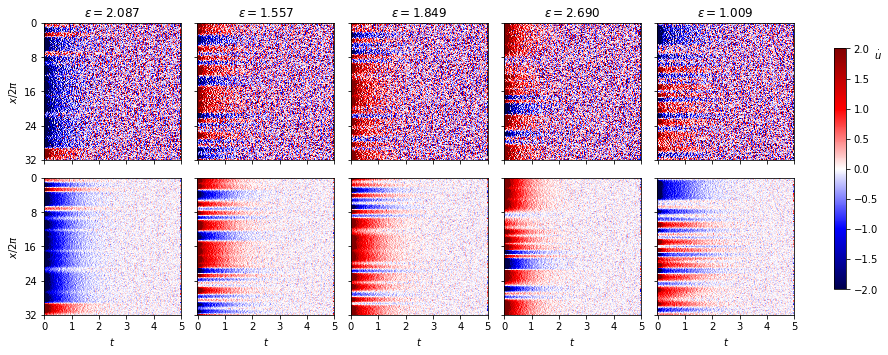

In [29]:
noise_scale = 0.05
np.random.seed(1)
xs_train_noisy = [
    xs_train[i] + noise_scale * np.random.normal(size=xs_train[i].shape)
    for i in range(len(xs_train))
]
xs_test_noisy = [
    xs_test[i] + noise_scale * np.random.normal(size=xs_test[i].shape)
    for i in range(len(xs_test))
]

noise_scale = 0.01
np.random.seed(1)
xs_train_noisy2 = [
    xs_train[i] + noise_scale * np.random.normal(size=xs_train[i].shape)
    for i in range(len(xs_train))
]
xs_test_noisy2 = [
    xs_test[i] + noise_scale * np.random.normal(size=xs_test[i].shape)
    for i in range(len(xs_test))
]

fig, ax = plt.subplots(2, 5, figsize=(12, 5))
for i in range(len(xs_train)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(
        ps.FiniteDifference(d=1, axis=1)._differentiate(xs_train_noisy[i], t=dt),
        aspect=xs_train[0].shape[1] / xs_train[0].shape[0],
        cmap="seismic",
    )
    plt.gca().set_yticks([0, 64, 128, 192, 256])
    plt.gca().set_yticklabels([])
    if i == 0:
        plt.ylabel(r"$x/2\pi$")
        plt.gca().set_yticklabels([0, 8, 16, 24, 32])
    plt.gca().set_xticks([0, 50, 100, 150, 200, 250])
    plt.gca().set_xticklabels([])
    plt.title(r"$\varepsilon=%.3f$" % (epsilons_train[i]))
    plt.clim(-2, 2)
for i in range(len(xs_train)):
    plt.subplot(2, 5, i + 6)
    plt.imshow(
        ps.FiniteDifference(d=1, axis=1)._differentiate(xs_train_noisy2[i], t=dt),
        aspect=xs_train[0].shape[1] / xs_train[0].shape[0],
        cmap="seismic",
    )
    plt.gca().set_yticks([0, 64, 128, 192, 256])
    plt.gca().set_yticklabels([])
    if i == 0:
        plt.ylabel(r"$x/2\pi$")
        plt.gca().set_yticklabels([0, 8, 16, 24, 32])
    plt.gca().set_xticks([0, 50, 100, 150, 200, 250])
    plt.gca().set_xticklabels([0, 1, 2, 3, 4, 5])
    plt.xlabel("$t$")
    plt.clim(-2, 2)

plt.tight_layout()
cb = plt.colorbar(ax=ax[:][:], fraction=0.015)
cb.set_label(r"$\dot{u}$", rotation="horizontal", loc="top")
plt.savefig("figs5.pdf")
plt.show()

In [30]:
start = timeit.default_timer()
library_functions = [lambda x: x, lambda x: x**3, lambda x: x**5]
function_names = [lambda x: x, lambda x: x + x + x, lambda x: x + x + x + x + x]
seed = 100
K = 1000
H_xt = [L / 32, t1 / 5]
np.random.seed(seed)
feature_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    derivative_order=4,
    spatiotemporal_grid=spatiotemporal_grid,
    include_interaction=False,
    function_names=function_names,
    multiindices=[[2], [4]],
    K=K,
    H_xt=H_xt,
)
library_functions = [lambda x: x, lambda x: x**2]
function_names = [lambda x: x, lambda x: x + "^2"]
np.random.seed(seed)
parameter_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    derivative_order=0,
    spatiotemporal_grid=spatiotemporal_grid,
    include_interaction=False,
    function_names=function_names,
    include_bias=True,
    K=K,
    H_xt=H_xt,
)
lib = ps.ParameterizedLibrary(
    parameter_library=parameter_lib,
    feature_library=feature_lib,
    num_parameters=1,
    num_features=1,
)
opt = ps.STLSQ(threshold=1e-3, alpha=1e-12, normalize_columns=False)
model = ps.SINDy(feature_library=lib, optimizer=opt, feature_names=["u", "epsilon"])

model.fit(
    xs_train_noisy,
    u=epsilons_train.tolist(),
    t=dt,
    multiple_trajectories=True,
)
model.print()
stop = timeit.default_timer()
print(stop - start)
print(lib.get_feature_names(["u", "epsilon"]))
utils.get_sh_coefficients(model)
print(
    model.score(
        xs_test_noisy, u=epsilons_train.tolist(), t=dt, multiple_trajectories=True
    )
)

print()

model.fit(
    xs_train_noisy2,
    u=epsilons_train.tolist(),
    t=dt,
    multiple_trajectories=True,
    unbias=True,
)
model.print()
stop = timeit.default_timer()
print(stop - start)
print(lib.get_feature_names(["u", "epsilon"]))
(
    r_func_fit,
    b3_func_fit,
    b5_func_fit,
    uxx_func_fit,
    uxxxx_func_fit,
) = utils.get_sh_coefficients(model)
print(
    model.score(
        xs_test_noisy2, u=epsilons_train.tolist(), t=dt, multiple_trajectories=True
    )
)

(u)' = -1.627 1 u + 1.128 1 uuu + 0.112 1 uuuuu + -1.702 1 u_11 + -0.880 1 u_1111 + -0.155 epsilon u + 0.547 epsilon uuu + -1.183 epsilon uuuuu + -0.354 epsilon u_11 + -0.126 epsilon u_1111 + 0.019 epsilon^2 u + -0.275 epsilon^2 uuu + 0.357 epsilon^2 uuuuu + 0.107 epsilon^2 u_11 + 0.047 epsilon^2 u_1111
3.2091596219688654
['1 u', '1 uuu', '1 uuuuu', '1 u_11', '1 u_1111', 'epsilon u', 'epsilon uuu', 'epsilon uuuuu', 'epsilon u_11', 'epsilon u_1111', 'epsilon^2 u', 'epsilon^2 uuu', 'epsilon^2 uuuuu', 'epsilon^2 u_11', 'epsilon^2 u_1111']
0.9977299067120184

(u)' = -1.680 1 u + 1.702 1 uuu + -0.684 1 uuuuu + -1.940 1 u_11 + -0.975 1 u_1111 + -0.086 epsilon u + -0.201 epsilon uuu + -0.125 epsilon uuuuu + -0.072 epsilon u_11 + -0.025 epsilon u_1111 + -0.047 epsilon^2 uuu + 0.022 epsilon^2 u_11 + 0.010 epsilon^2 u_1111
8.455607146024704
['1 u', '1 uuu', '1 uuuuu', '1 u_11', '1 u_1111', 'epsilon u', 'epsilon uuu', 'epsilon uuuuu', 'epsilon u_11', 'epsilon u_1111', 'epsilon^2 u', 'epsilon^2 uu

Fit the low-$\varepsilon$ data with weak SINDyCP with noise intensity $\sigma=0.05$ and $\sigma=0.01$

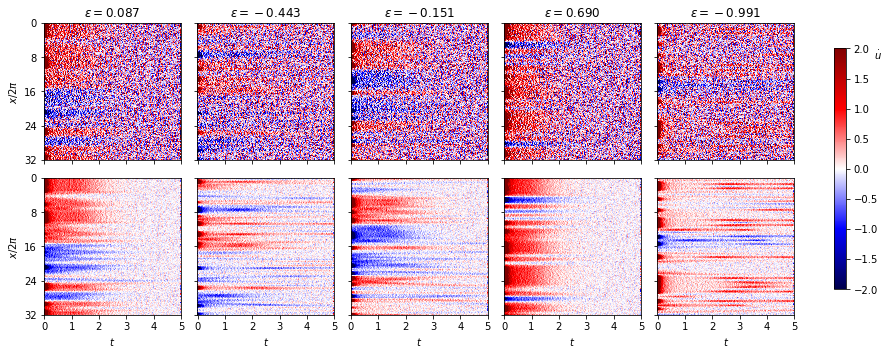

In [31]:
noise_scale = 0.05
np.random.seed(1)
xs_train_noisy3 = [
    xs_train2[i] + noise_scale * np.random.normal(size=xs_train2[i].shape)
    for i in range(len(xs_train2))
]
xs_test_noisy3 = [
    xs_test2[i] + noise_scale * np.random.normal(size=xs_test2[i].shape)
    for i in range(len(xs_test2))
]

noise_scale = 0.01
np.random.seed(1)
xs_train_noisy4 = [
    xs_train2[i] + noise_scale * np.random.normal(size=xs_train2[i].shape)
    for i in range(len(xs_train2))
]
xs_test_noisy4 = [
    xs_test2[i] + noise_scale * np.random.normal(size=xs_test2[i].shape)
    for i in range(len(xs_test2))
]

fig, ax = plt.subplots(2, 5, figsize=(12, 5))

for i in range(len(xs_train)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(
        ps.FiniteDifference(d=1, axis=1)._differentiate(xs_train_noisy3[i], t=dt),
        aspect=xs_train2[0].shape[1] / xs_train2[0].shape[0],
        cmap="seismic",
    )
    plt.gca().set_yticks([0, 64, 128, 192, 256])
    plt.gca().set_yticklabels([])
    if i == 0:
        plt.ylabel(r"$x/2\pi$")
        plt.gca().set_yticklabels([0, 8, 16, 24, 32])
    plt.gca().set_xticks([0, 50, 100, 150, 200, 250])
    plt.gca().set_xticklabels([0, 1, 2, 3, 4, 5])
    plt.gca().set_xticklabels([])
    plt.title(r"$\varepsilon=%.3f$" % (epsilons_train2[i]))

    plt.clim(-2, 2)
for i in range(len(xs_train)):
    plt.subplot(2, 5, i + 6)
    plt.imshow(
        ps.FiniteDifference(d=1, axis=1)._differentiate(xs_train_noisy4[i], t=dt),
        aspect=xs_train[0].shape[1] / xs_train[0].shape[0],
        cmap="seismic",
    )
    plt.gca().set_yticks([0, 64, 128, 192, 256])
    plt.gca().set_yticklabels([])
    if i == 0:
        plt.ylabel(r"$x/2\pi$")
        plt.gca().set_yticklabels([0, 8, 16, 24, 32])
    plt.gca().set_xticks([0, 50, 100, 150, 200, 250])
    plt.gca().set_xticklabels([0, 1, 2, 3, 4, 5])
    plt.xlabel("$t$")
    plt.clim(-2, 2)


plt.tight_layout()
cb = plt.colorbar(ax=ax[:][:], fraction=0.015)
cb.set_label(r"$\dot{u}$", rotation="horizontal", loc="top")
plt.savefig("figs6.pdf")
plt.show()

In [32]:
start = timeit.default_timer()
library_functions = [
    lambda x: x,
    lambda x: x**2,
    lambda x: x**3,
    lambda x: x**4,
    lambda x: x**5,
]
function_names = [
    lambda x: x,
    lambda x: x + x,
    lambda x: x + x + x,
    lambda x: x + x + x + x,
    lambda x: x + x + x + x + x,
]
library_functions = [lambda x: x, lambda x: x**3, lambda x: x**5]
function_names = [lambda x: x, lambda x: x + x + x, lambda x: x + x + x + x + x]


model.fit(
    xs_train_noisy3,
    u=epsilons_train2.tolist(),
    t=dt,
    multiple_trajectories=True,
    unbias=True,
)
model.print()
stop = timeit.default_timer()
print(stop - start)
print(lib.get_feature_names(["u", "epsilon"]))
utils.get_sh_coefficients(model)
print(
    model.score(
        xs_test_noisy3, u=epsilons_train2.tolist(), t=dt, multiple_trajectories=True
    )
)

print()
model.fit(
    xs_train_noisy4,
    u=epsilons_train2.tolist(),
    t=dt,
    multiple_trajectories=True,
    unbias=True,
)
model.print()
stop = timeit.default_timer()
print(stop - start)
print(lib.get_feature_names(["u", "epsilon"]))
utils.get_sh_coefficients(model)
print(
    model.score(
        xs_test_noisy4, u=epsilons_train2.tolist(), t=dt, multiple_trajectories=True
    )
)

(u)' = -1.703 1 u + 1.809 1 uuu + -0.760 1 uuuuu + -2.009 1 u_11 + -1.014 1 u_1111 + -0.079 epsilon u + -0.264 epsilon uuu + -0.077 epsilon uuuuu + 0.014 epsilon u_11 + -0.005 epsilon u_1111 + 0.005 epsilon^2 u + -0.009 epsilon^2 uuu + -0.016 epsilon^2 uuuuu + 0.041 epsilon^2 u_11 + 0.019 epsilon^2 u_1111
3.622263150755316
['1 u', '1 uuu', '1 uuuuu', '1 u_11', '1 u_1111', 'epsilon u', 'epsilon uuu', 'epsilon uuuuu', 'epsilon u_11', 'epsilon u_1111', 'epsilon^2 u', 'epsilon^2 uuu', 'epsilon^2 uuuuu', 'epsilon^2 u_11', 'epsilon^2 u_1111']
0.9989307337006449

(u)' = -1.692 1 u + 1.793 1 uuu + -0.760 1 uuuuu + -2.001 1 u_11 + -1.002 1 u_1111 + -0.075 epsilon u + -0.296 epsilon uuu + -0.061 epsilon uuuuu + 0.004 epsilon u_11 + -0.001 epsilon^2 u + -0.021 epsilon^2 uuu + -0.008 epsilon^2 uuuuu + 0.009 epsilon^2 u_11 + 0.005 epsilon^2 u_1111
9.007282468955964
['1 u', '1 uuu', '1 uuuuu', '1 u_11', '1 u_1111', 'epsilon u', 'epsilon uuu', 'epsilon uuuuu', 'epsilon u_11', 'epsilon u_1111', 'epsil

Plot the normal form parameters and continuation results

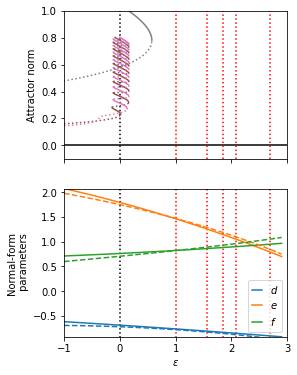

In [33]:
plt.subplots(2, 1, figsize=(4, 6))

plt.subplot(2, 1, 1)
plt.plot(np.arange(-1, 4, 1), np.zeros(5), c="black")
for epsilon in epsilons_train:
    plt.plot([epsilon, epsilon], [-0.1, 1], ls=":", c="red")
plt.plot([0.0, 0.0], [-0.1, 1], ls=":", c="black")

unstable, stable = utils.get_auto_branches("data/auto/odd")
for branch in stable:
    plt.plot(branch[0], branch[1], c=colors[5])
for branch in unstable:
    plt.plot(branch[0], branch[1], ls=":", c=colors[5])
unstable, stable = utils.get_auto_branches("data/auto/even")
for branch in stable:
    plt.plot(branch[0], branch[1], c=colors[6])
for branch in unstable:
    plt.plot(branch[0], branch[1], ls=":", c=colors[6])
unstable, stable = utils.get_auto_branches("data/auto/periodic")
for branch in stable:
    plt.plot(branch[0], branch[1], c=colors[7])
for branch in unstable:
    plt.plot(branch[0], branch[1], ls=":", c=colors[7])

plt.xlim(-1, 3)
plt.ylim(-0.1, 1)
plt.ylabel("Attractor norm")
plt.gca().set_xticklabels([])

plt.subplot(2, 1, 2)
epsilons = np.arange(-1, 3, 0.1)
mn = np.min([r_func(epsilons), b3_func(epsilons), b5_func(epsilons)])
mx = np.max([r_func(epsilons), b3_func(epsilons), b5_func(epsilons)])
for epsilon in epsilons_train:
    plt.plot([epsilon, epsilon], [mx, mn], ls=":", c="red")
plt.plot([0, 0], [mx, mn], ls=":", c="black")

line1 = plt.plot(epsilons, r_func(epsilons), label="$d$")
line2 = plt.plot(epsilons, b3_func(epsilons), label="$e$")
line3 = plt.plot(epsilons, b5_func(epsilons), label="$f$")

plt.plot(
    epsilons,
    1 - (r_func_fit(epsilons) - 1) / uxxxx_func_fit(epsilons),
    c=line1[0].get_color(),
    ls="--",
)
plt.plot(
    epsilons,
    -b3_func_fit(epsilons) / uxxxx_func_fit(epsilons),
    c=line2[0].get_color(),
    ls="--",
)
plt.plot(
    epsilons,
    -b5_func_fit(epsilons) / uxxxx_func_fit(epsilons),
    c=line3[0].get_color(),
    ls="--",
)

h, lab = plt.gca().get_legend_handles_labels()
plt.legend(h, lab, handlelength=1)
plt.ylim(mn, mx)
plt.xlim(-1, 3)
plt.xlabel(r"$\varepsilon$")
plt.ylabel("Normal-form\n parameters")

plt.savefig("fig4a.pdf")
plt.show()

Extrapolate the model to parameters with twentry random initial conditions. The fit correctly predicts the localized states!

In [34]:
def sh_fit(t, u, epsilon):
    ux = np.real(ps.SpectralDerivative(d=1, axis=0)._differentiate(u, L / nx))
    uxx = np.real(ps.SpectralDerivative(d=2, axis=0)._differentiate(u, L / nx))
    uxxx = np.real(ps.SpectralDerivative(d=3, axis=0)._differentiate(u, L / nx))
    uxxxx = np.real(ps.SpectralDerivative(d=4, axis=0)._differentiate(u, L / nx))
    return (
        +uxx_func_fit([epsilon])[0] * uxx
        + uxxxx_func_fit([epsilon])[0] * uxxxx
        + (r_func_fit([epsilon])[0] - 1) * u
        + b3_func_fit([epsilon])[0] * u**3
        - b5_func_fit([epsilon])[0] * u**5
    )


nx = 256
L = 2 * np.pi * 16
t1 = 50
N = nx
dt = 1

epsilon = 0.0
k = 2

xs_test = []
seeds = [1, 5]
start = timeit.default_timer()
for i in seeds:
    np.random.seed(i)
    ks = np.arange(-20, 21) / L
    u0 = np.zeros((nx), dtype=np.complex128)
    scale0 = 0.5
    for kx in ks:
        scale = scale0 / (1 + np.abs(L * kx) ** 0.5)
        u0 += (
            scale
            * (np.random.normal(0, 1) + 1j * np.random.normal(0, 1))
            * np.exp(1j * (2 * np.pi * kx * np.arange(nx) / nx * L))
        )
    u = np.real(u0)
    us = np.zeros((int(t1 / dt), nx))

    t = 0
    for n in range(int(t1 / dt)):
        t = n * dt
        print("%d %.3f" % (i, t / t1), end="\r")
        sol = solve_ivp(
            sh_fit,
            [t, t + dt],
            u,
            method="LSODA",
            args=(epsilon,),
            rtol=1e-6,
            atol=1e-6,
            first_step=dt / 1000,
        )
        u = sol.y[:, -1]
        us[n] = u
    xs_test.append(np.transpose(us)[:, :, np.newaxis])
stop = timeit.default_timer()
print(stop - start)

81.18835631897673


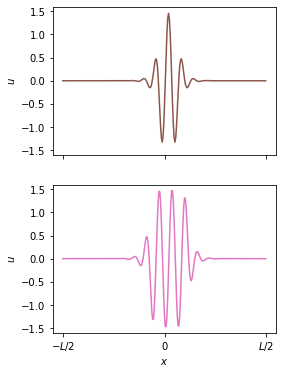

In [35]:
plt.subplots(2, 1, figsize=(4, 6))

plt.subplot(2, 1, 1)
u = xs_test[0][:, -1]
ux = ps.SpectralDerivative(d=1, axis=0)._differentiate(u, L / nx)
u = np.roll(u, nx // 2 - np.argmax(ux) + 1)
plt.plot(u, c=colors[5])
plt.ylim(-1.6, 1.6)
plt.ylabel("$u$")
plt.gca().set_xticks([0, 128, 256])
plt.gca().set_xticklabels([])

plt.subplot(2, 1, 2)
u = xs_test[1][:, -1]
u = np.roll(u, nx // 2 - np.argmin(u) + 1)
plt.plot(u, c=colors[6])
plt.ylim(-1.6, 1.6)
plt.xlabel("$x$")
plt.ylabel("$u$")
plt.gca().set_xticks([0, 128, 256])
plt.gca().set_xticklabels(["$-L/2$", "$0$", "$L/2$"])

plt.savefig("fig4b.pdf")

Compare the snaking bifurcations for the fits and the actual equations

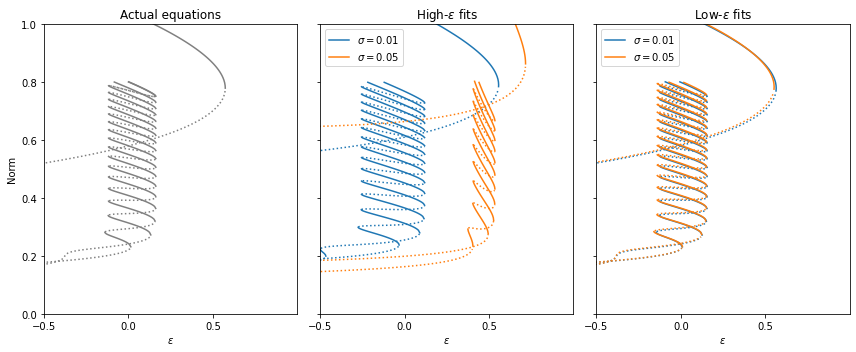

In [36]:
plt.subplots(1, 3, figsize=(12, 5))

unstable, stable = utils.get_auto_branches("data/auto/odd")
plt.subplot(1, 3, 1)
for branch in stable:
    plt.plot(branch[0], branch[1], c="gray")
for branch in unstable:
    plt.plot(branch[0], branch[1], ls=":", c="gray")
unstable, stable = utils.get_auto_branches("data/auto/even")
for branch in stable:
    plt.plot(branch[0], branch[1], c="gray")
for branch in unstable:
    plt.plot(branch[0], branch[1], ls=":", c="gray")
unstable, stable = utils.get_auto_branches("data/auto/periodic")
for branch in stable:
    plt.plot(branch[0], branch[1], c="gray")
for branch in unstable:
    plt.plot(branch[0], branch[1], ls=":", c="gray")
plt.xlabel(r"$\varepsilon$")
plt.ylabel("Norm")
plt.ylim(0, 1)
plt.xlim(-0.5, 1)
plt.gca().set_xticks([-0.5, 0, 0.5])
plt.gca().set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.title("Actual equations")

unstable, stable = utils.get_auto_branches("data/auto/odd2")
plt.subplot(1, 3, 3)
lab = True
for branch in stable:
    if lab:
        plt.plot(branch[0], branch[1], c=colors[2], label=r"$\sigma=0.01$")
        lab = False
    else:
        plt.plot(branch[0], branch[1], c=colors[2])
for branch in unstable:
    plt.plot(branch[0], branch[1], ls=":", c=colors[2])
unstable, stable = utils.get_auto_branches("data/auto/even2")
for branch in stable:
    plt.plot(branch[0], branch[1], c=colors[2])
for branch in unstable:
    plt.plot(branch[0], branch[1], ls=":", c=colors[2])
unstable, stable = utils.get_auto_branches("data/auto/periodic2")
for branch in stable:
    plt.plot(branch[0], branch[1], c=colors[2])
for branch in unstable:
    plt.plot(branch[0], branch[1], ls=":", c=colors[2])
unstable, stable = utils.get_auto_branches("data/auto/odd4")
lab = True
for branch in stable:
    if lab:
        plt.plot(branch[0], branch[1], c=colors[0], label=r"$\sigma=0.05$")
        lab = False
    else:
        plt.plot(branch[0], branch[1], c=colors[0])
for branch in unstable:
    plt.plot(branch[0], branch[1], ls=":", c=colors[0])
unstable, stable = utils.get_auto_branches("data/auto/even4")
for branch in stable:
    plt.plot(branch[0], branch[1], c=colors[0])
for branch in unstable:
    plt.plot(branch[0], branch[1], ls=":", c=colors[0])
unstable, stable = utils.get_auto_branches("data/auto/periodic4")
for branch in stable:
    plt.plot(branch[0], branch[1], c=colors[0])
for branch in unstable:
    plt.plot(branch[0], branch[1], ls=":", c=colors[0])
plt.legend()
plt.xlabel(r"$\varepsilon$")
plt.ylim(0, 1)
plt.xlim(-0.5, 1)
plt.gca().set_xticks([-0.5, 0, 0.5])
plt.gca().set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.gca().set_yticklabels([])
plt.title(r"Low-$\varepsilon$ fits")

unstable, stable = utils.get_auto_branches("data/auto/odd3")
plt.subplot(1, 3, 2)
lab = True
for branch in stable:
    if lab:
        plt.plot(branch[0], branch[1], c=colors[2], label=r"$\sigma=0.01$")
        lab = False
    else:
        plt.plot(branch[0], branch[1], c=colors[2])
for branch in unstable:
    plt.plot(branch[0], branch[1], ls=":", c=colors[2])
unstable, stable = utils.get_auto_branches("data/auto/even3")
for branch in stable:
    plt.plot(branch[0], branch[1], c=colors[2])
for branch in unstable:
    plt.plot(branch[0], branch[1], ls=":", c=colors[2])
unstable, stable = utils.get_auto_branches("data/auto/periodic3")
for branch in stable:
    plt.plot(branch[0], branch[1], c=colors[2])
for branch in unstable:
    plt.plot(branch[0], branch[1], ls=":", c=colors[2])
unstable, stable = utils.get_auto_branches("data/auto/odd5")
lab = True
for branch in stable:
    if lab:
        plt.plot(branch[0], branch[1], c=colors[0], label=r"$\sigma=0.05$")
        lab = False
    else:
        plt.plot(branch[0], branch[1], c=colors[0])
for branch in unstable:
    plt.plot(branch[0], branch[1], ls=":", c=colors[0])
unstable, stable = utils.get_auto_branches("data/auto/even5")
for branch in stable:
    plt.plot(branch[0], branch[1], c=colors[0])
for branch in unstable:
    plt.plot(branch[0], branch[1], ls=":", c=colors[0])
unstable, stable = utils.get_auto_branches("data/auto/periodic5")
for branch in stable:
    plt.plot(branch[0], branch[1], c=colors[0])
for branch in unstable:
    plt.plot(branch[0], branch[1], ls=":", c=colors[0])
plt.legend()

plt.xlabel(r"$\varepsilon$")
plt.ylim(0, 1)
plt.xlim(-0.5, 1)
plt.gca().set_xticks([-0.5, 0, 0.5])
plt.gca().set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.gca().set_yticklabels([])
plt.title(r"High-$\varepsilon$ fits")

plt.tight_layout()
plt.savefig("figs7.pdf")
plt.show()